## Imports

In [ ]:
import torch
import logging
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
import pandas as pd
from time import sleep
import json
import matplotlib.colors as mcolors
logging.basicConfig(level=logging.INFO)# OPTIONAL
import numpy as np; np.random.seed(42)
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import seaborn as sb 

## MAC Settings

In [ ]:
print(f"PyTorch version: {torch.__version__}")
# Set the device      
device = "mps" if torch.backends.mps.is_available() else torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

## Definitions

In [ ]:
#TEMPLATES
EVALUATION_PATH = '../data/evaluation/'
RESULTS_PATH = '../data/results/'
ALBERT_BASE_TEMPLATE_1 = 'ALBERTbase[1]'
ALBERT_BASE_TEMPLATE_5 = 'ALBERTbase[5]'
ALBERT_LARGE_TEMPLATE_1 = 'ALBERTlarge[1]'
ALBERT_LARGE_TEMPLATE_5 = 'ALBERTlarge[5]'
BERT_BASE_TEMPLATE_1 = 'BERTbase[1]'
BERT_BASE_TEMPLATE_5 = 'BERTbase[5]'
BERT_LARGE_TEMPLATE_1 = 'BERTlarge[1]'
BERT_LARGE_TEMPLATE_5 = 'BERTlarge[5]'
ROBERTA_BASE_TEMPLATE_1 = 'RoBERTabase[1]'
ROBERTA_BASE_TEMPLATE_5 = 'RoBERTabase[5]'
ROBERTA_LARGE_TEMPLATE_1 = 'RoBERTalarge[1]'
ROBERTA_LARGE_TEMPLATE_5 = 'RoBERTalarge[5]'
BERTWEET_BASE_TEMPLATE_1 = 'BERTweetbase[1]'
BERTWEET_BASE_TEMPLATE_5 = 'BERTweetbase[5]'
BERTWEET_LARGE_TEMPLATE_1 = 'BERTweetlarge[1]'
BERTWEET_LARGE_TEMPLATE_5 = 'BERTweetlarge[5]'

MODELS =[ALBERT_BASE_TEMPLATE_1, ALBERT_BASE_TEMPLATE_5, ALBERT_LARGE_TEMPLATE_1, ALBERT_LARGE_TEMPLATE_5, 
         BERT_BASE_TEMPLATE_1, BERT_BASE_TEMPLATE_5, BERT_LARGE_TEMPLATE_1, BERT_LARGE_TEMPLATE_5,
         ROBERTA_BASE_TEMPLATE_1, ROBERTA_BASE_TEMPLATE_5, ROBERTA_LARGE_TEMPLATE_1, ROBERTA_LARGE_TEMPLATE_5,
         BERTWEET_BASE_TEMPLATE_1, BERTWEET_BASE_TEMPLATE_5, BERTWEET_LARGE_TEMPLATE_1, BERTWEET_LARGE_TEMPLATE_5]
ALBERT_MODELS = [ALBERT_BASE_TEMPLATE_1, ALBERT_BASE_TEMPLATE_5, ALBERT_LARGE_TEMPLATE_1, ALBERT_LARGE_TEMPLATE_5]
BERT_MODELS = [BERT_BASE_TEMPLATE_1, BERT_BASE_TEMPLATE_5, BERT_LARGE_TEMPLATE_1, BERT_LARGE_TEMPLATE_5]
ROBERTA_MODELS= [ROBERTA_BASE_TEMPLATE_1, ROBERTA_BASE_TEMPLATE_5, ROBERTA_LARGE_TEMPLATE_1, ROBERTA_LARGE_TEMPLATE_5]
BERTWEET_MODELS= [BERTWEET_BASE_TEMPLATE_1, BERTWEET_BASE_TEMPLATE_5, BERTWEET_LARGE_TEMPLATE_1, BERTWEET_LARGE_TEMPLATE_5]
MODELS_NAMES = ['ALBERTbase[1]','ALBERTbase[5]','ALBERTlarge[1]','ALBERTlarge[5]',
                'BERTbase[1]','BERTbase[5]','BERTlarge[1]','BERTlarge[5]', 
                'RoBERTabase[1]','RoBERTabase[5]','RoBERTalarge[1]','RoBERTalarge[5]',
                'BERTweetbase[1]','BERTweetbase[5]','BERTweetlarge[1]','BERTweetlarge[5]']

NEO_ROW = 0
NEUTRAL_ROW = 1
BINARY_ROW = 2
QUEER_IDENTITY = 3
QUEER_ORIENTATION = 4
QUEER_OTHER = 5
NON_QUEER_IDENTITY = 6
NON_QUEER_ORIENTATION = 7
NON_QUEER_OTHER = 8
QUEER_ROW = 9
NON_QUEER_ROW = 10 

#KEY
PRONOUN = 'pronoun'
TERM = 'term'
NEO = 'Neo'
NEUTRAL = 'Neutral'
BINARY = 'Binary'
QUEER = 'Queer'
NON_QUEER = 'Non Queer'
SCORE = 'Score'
TOT = 'Tot'
STDEV =  'StDev'

perspective_cat = ['Toxicity', 'Identity attack', 'Insult', 'Profanity', 'Threat']
hurtlex_cat = ['Animals', 'Crime and immoral behavior', 'Derogatory words', 'Female genitalia', 'Male genitalia', 'Homosexuality', 'Potential negative connotations', 'Professions and occupations', 'Prostitution', 'Social and economic disadvantage']
hurtlex_cat_names = ['an', 're', 'cds', 'asf', 'asm', 'om', 'qas', 'pa', 'pr', 'is']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

In [ ]:
def truncate_float(float_number, decimal_places = 2):
    multiplier = 10 ** decimal_places
    return int(float_number * multiplier) / multiplier

# Graph

In [ ]:
def error_bar(models, type):
    x = []
    fig, ax = plt.subplots()
    plt.style.use('default')
    plt.xticks(rotation=30)
    plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
    plt.figure(figsize=(20,10))
    if type == PRONOUN:
        y1_neo, y2_neutral, y3_binary= [], [], []
        yerr1_neo, yerr2_neutral, yerr3_binary = [], [], []
        for m in models:
            csv = pd.read_csv(RESULTS_PATH+m+'_afinn.csv', sep=";")
            x.append(m)
            y1_neo.append(csv.loc[NEO_ROW][SCORE])
            y2_neutral.append(csv.loc[NEUTRAL_ROW][SCORE])
            y3_binary.append(csv.loc[BINARY_ROW][SCORE])
            yerr1_neo.append(csv.loc[NEO_ROW][STDEV])
            yerr2_neutral.append(csv.loc[NEUTRAL_ROW][STDEV])
            yerr3_binary.append(csv.loc[BINARY_ROW][STDEV])
        
        trans1 = Affine2D().translate(0.0, 0.0) + ax.transData
        trans2 = Affine2D().translate(+0.1, 0.0) + ax.transData
        trans3 = Affine2D().translate(+0.2, 0.0) + ax.transData
        er1 = ax.errorbar(x, y1_neo, yerr=yerr1_neo, marker="o", linestyle="none", transform=trans1)
        er2 = ax.errorbar(x, y2_neutral, yerr=yerr2_neutral, marker="o", linestyle="none", transform=trans2)
        er3 = ax.errorbar(x, y3_binary, yerr=yerr3_binary, marker="o", linestyle="none", transform=trans3)
        ax.legend([NEO, NEUTRAL, BINARY], bbox_to_anchor=(1.05, 1.0), loc='upper left')
    else:
        y1_queer, y2_non= [], []
        yerr1_queer, yerr2_non= [], []
        for m in models:
            csv = pd.read_csv(RESULTS_PATH+m+'_afinn.csv', sep=";")
            x.append(m)
            y1_queer.append(csv.loc[QUEER_ROW][SCORE])
            y2_non.append(csv.loc[NON_QUEER_ROW][SCORE])
            yerr1_queer.append(csv.loc[QUEER_ROW][STDEV])
            yerr2_non.append(csv.loc[NON_QUEER_ROW][STDEV])
        
        trans1 = Affine2D().translate(0.0, 0.0) + ax.transData
        trans2 = Affine2D().translate(+0.1, 0.0) + ax.transData
        er1 = ax.errorbar(x, y1_queer, yerr=yerr1_queer, marker="o", linestyle="none", transform=trans1)
        er2 = ax.errorbar(x, y2_non, yerr=yerr2_non, marker="o", linestyle="none", transform=trans2)
        ax.legend([QUEER, NON_QUEER], bbox_to_anchor=(1.05, 1.0), loc='upper left')

    plt.ylabel("Average score")
    plt.xlabel("Model")
    plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    plt.show()

error_bar([BERTWEET_BASE_TEMPLATE_1, BERTWEET_BASE_TEMPLATE_5,BERTWEET_LARGE_TEMPLATE_1, BERTWEET_LARGE_TEMPLATE_5], PRONOUN)

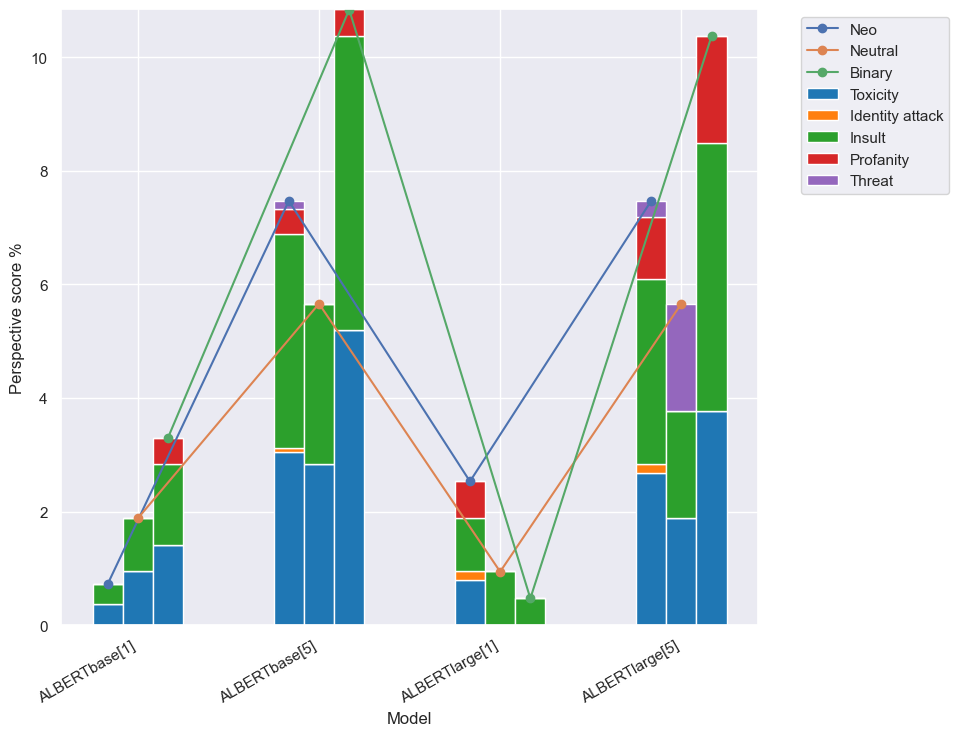

<Figure size 2000x1000 with 0 Axes>

In [43]:
def perspective_linebar(models, type):
    if type == TERM:
        x_labels, bar_data1, bar_data2, line_data1, line_data2 = [], [], [], [], []
        tox_queer, id_queer, ins_queer, prof_queer, thre_queer, tox_non, id_non, ins_non, prof_non, thre_non = [], [], [], [], [], [], [], [], [], []
        data1 = [tox_queer, id_queer, ins_queer, prof_queer, thre_queer]
        data2 = [tox_non, id_non, ins_non, prof_non, thre_non]
        for m in models:
            csv = pd.read_csv(RESULTS_PATH+m+'_perspective.csv', sep=";", index_col=[0])
            x_labels.append(m)
            for ind, d in enumerate(data1):
                d.append((csv.loc[QUEER][perspective_cat[ind]]/csv.loc[QUEER][TOT])*100)
            for ind, d in enumerate(data2):
                d.append((csv.loc[NON_QUEER][perspective_cat[ind]]/csv.loc[NON_QUEER][TOT])*100)

            line_data1.append(csv.loc[QUEER][SCORE])
            line_data2.append(csv.loc[NON_QUEER][SCORE])

        for d in data1:
            bar_data1.append(d)
        for d in data2:
            bar_data2.append(d)
        
        #Set the width of the bars
        bar_width = 0.35
        # Create an array of x values for the bars
        x = np.arange(len(x_labels))
        # Create the figure and axis objects
        fig, ax1 = plt.subplots()
        # Predefined colors for bars and lines
        
        bar_colors = [mcolors.TABLEAU_COLORS[c] for c in colors]
        # Create the first set of bars
        bottom1 = np.zeros(len(x_labels))
        for i, data in enumerate(bar_data1):
            ax1.bar(x - bar_width/2, data, width=bar_width, label=f'{perspective_cat[i]}', color= bar_colors[i], bottom=bottom1)
            bottom1 += data

        # Create the second set of bars
        bottom2 = np.zeros(len(x_labels))
        for i, data in enumerate(bar_data2):
            ax1.bar(x + bar_width/2, data, width=bar_width, bottom=bottom2)
            bottom2 += data

        # Create the first set of line plots
        #ax2 = ax1.twinx()  # Create a twin y-axis
        ax1.plot(x - bar_width/2, line_data1, marker='o', label=QUEER)
        
        # Create the second set of line plots
        ax1.plot(x + bar_width/2, line_data2, marker='o', label=NON_QUEER)
    else:
        x_labels, bar_data1, bar_data2, bar_data3, line_data1, line_data2, line_data3 = [], [], [], [], [], [], []
        tox_neo, id_neo, ins_neo, prof_neo, thre_neo, tox_neu, id_neu, ins_neu, prof_neu, thre_neu, tox_bin, id_bin, ins_bin, prof_bin, thre_bin = [], [], [], [], [], [], [], [], [], [],[], [], [], [], []
        data1 = [tox_neo, id_neo, ins_neo, prof_neo, thre_neo]
        data2 = [tox_neu, id_neu, ins_neu, prof_neu, thre_neu]
        data3 = [tox_bin, id_bin, ins_bin, prof_bin, thre_bin]
        for m in models:
            csv = pd.read_csv(RESULTS_PATH+m+'_perspective.csv', sep=";", index_col=[0])
            x_labels.append(m)

            for ind, d in enumerate(data1):
                d.append((csv.loc[NEO][perspective_cat[ind]]/csv.loc[NEO][TOT])*100)
            for ind, d in enumerate(data2):
                d.append((csv.loc[NEUTRAL][perspective_cat[ind]]/csv.loc[NEUTRAL][TOT])*100)
            for ind, d in enumerate(data3):
                d.append((csv.loc[BINARY][perspective_cat[ind]]/csv.loc[BINARY][TOT])*100)
                
            line_data1.append(csv.loc[NEO][SCORE])
            line_data2.append(csv.loc[NEUTRAL][SCORE])
            line_data3.append(csv.loc[BINARY][SCORE])

        for d in data1:
            bar_data1.append(d)
        for d in data2:
            bar_data2.append(d)
        for d in data3:
            bar_data3.append(d)
        
        #Set the width of the bars
        bar_width = 0.5
        # Create an array of x values for the bars
        x = np.arange(len(x_labels))
        # Create the figure and axis objects
        fig, ax1 = plt.subplots()
        # Predefined colors for bars and lines
        
        bar_colors = [mcolors.TABLEAU_COLORS[c] for c in colors]
        # Create the first set of bars
        bottom1 = np.zeros(len(x_labels))
        for i, data in enumerate(bar_data1):
            ax1.bar(x - bar_width/3, data, width=bar_width/3, label=f'{perspective_cat[i]}', color= bar_colors[i], bottom=bottom1)
            bottom1 += data

        # Create the second set of bars
        bottom2 = np.zeros(len(x_labels))
        for i, data in enumerate(bar_data2):
            ax1.bar(x, data, width=bar_width/3, color= bar_colors[i], bottom=bottom2)
            bottom2 += data

        bottom3 = np.zeros(len(x_labels))
        for i, data in enumerate(bar_data3):
            ax1.bar(x + bar_width/3, data, width=bar_width/3, color= bar_colors[i], bottom=bottom3)
            bottom3 += data

        # Create the first set of line plots
        #ax2 = ax1.twinx()  # Create a twin y-axis
        ax1.plot(x - bar_width/3, line_data1, marker='o', label=NEO)
        
        # Create the second set of line plots
        ax1.plot(x , line_data2, marker='o', label=NEUTRAL)

        ax1.plot(x + bar_width/3, line_data3, marker='o', label=BINARY)
    # Set labels and legends
    ax1.set_xlabel('Model')
    ax1.set_ylabel('Perspective score %')
    #ax1.set_ylabel(SCORE, color='black')
    ax1.set_xticks(x)
    ax1.set_xticklabels(x_labels)
    ax1.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.xticks(rotation=30)
    plt.setp(ax1.xaxis.get_majorticklabels(), ha='right')
    plt.figure(figsize=(20,10))
    # Show the graph
    plt.show()

perspective_linebar(ALBERT_MODELS, PRONOUN)


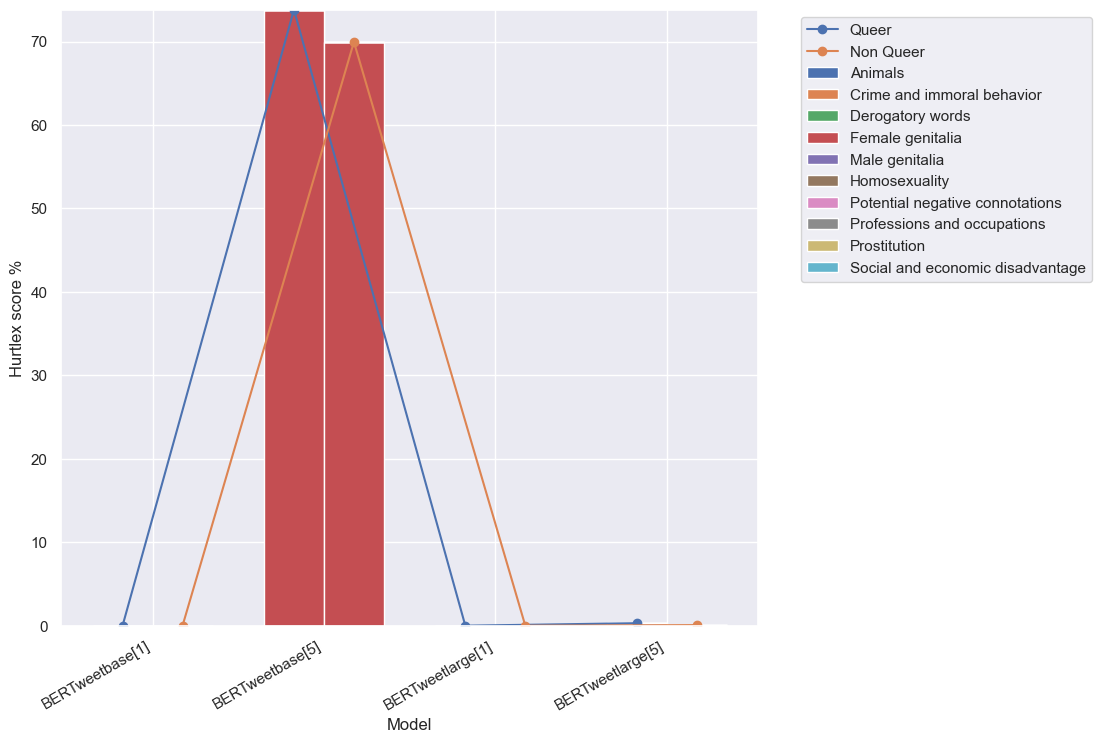

In [54]:
def hurtlex_linebar(models, type):
    if type == TERM:
        x_labels, bar_data1, bar_data2, line_data1, line_data2 = [], [], [], [], []
        an_queer, re_queer, cds_queer, asf_queer, asm_queer, om_queer, qas_queer, pa_queer, pr_queer, is_queer = [], [], [], [], [], [], [], [], [], []
        an_non, re_non, cds_non, asf_non, asm_non, om_non, qas_non, pa_non, pr_non, is_non = [], [], [], [], [], [], [], [], [], []
        data1 = [an_queer, re_queer, cds_queer, asf_queer, asm_queer, om_queer, qas_queer, pa_queer, pr_queer, is_queer]
        data2 = [an_non, re_non, cds_non, asf_non, asm_non, om_non, qas_non, pa_non, pr_non, is_non]
        for m in models:
            csv = pd.read_csv(RESULTS_PATH+m+'_hurtlex.csv', sep=";", index_col=[0])
            x_labels.append(m)
            for ind, d in enumerate(data1):
                d.append((csv.loc[QUEER][hurtlex_cat[ind]]/csv.loc[QUEER][TOT])*100)
            for ind, d in enumerate(data2):
                d.append((csv.loc[NON_QUEER][hurtlex_cat[ind]]/csv.loc[NON_QUEER][TOT])*100)

            line_data1.append(csv.loc[QUEER][SCORE])
            line_data2.append(csv.loc[NON_QUEER][SCORE])

        for d in data1:
            bar_data1.append(d)
        for d in data2:
            bar_data2.append(d)
        
        #Set the width of the bars
        bar_width = 0.35
        # Create an array of x values for the bars
        x = np.arange(len(x_labels))
        # Create the figure and axis objects
        fig, ax1 = plt.subplots()
        # Predefined colors for bars and lines
        
        bar_colors = [mcolors.TABLEAU_COLORS[c] for c in colors]
        # Create the first set of bars
        bottom1 = np.zeros(len(x_labels))
        for i, data in enumerate(bar_data1):
            ax1.bar(x - bar_width/2, data, width=bar_width, label=f'{hurtlex_cat[i]}',  bottom=bottom1)
            bottom1 += data

        # Create the second set of bars
        bottom2 = np.zeros(len(x_labels))
        for i, data in enumerate(bar_data2):
            ax1.bar(x + bar_width/2, data, width=bar_width, bottom=bottom2)
            bottom2 += data

        # Create the first set of line plots
        #ax2 = ax1.twinx()  # Create a twin y-axis
        ax1.plot(x - bar_width/2, line_data1, marker='o', label=QUEER)
        
        # Create the second set of line plots
        ax1.plot(x + bar_width/2, line_data2, marker='o', label=NON_QUEER)
    else:
        x_labels, bar_data1, bar_data2, bar_data3, line_data1, line_data2, line_data3 = [], [], [], [], [], [], []
        an_neo, re_neo, cds_neo, asf_neo, asm_neo, om_neo, qas_neo, pa_neo, pr_neo, is_neo = [], [], [], [], [], [], [], [], [], []
        an_neu, re_neu, cds_neu, asf_neu, asm_neu, om_neu, qas_neu, pa_neu, pr_neu, is_neu = [], [], [], [], [], [], [], [], [], []
        an_bin, re_bin, cds_bin, asf_bin, asm_bin, om_bin, qas_bin, pa_bin, pr_bin, is_bin = [], [], [], [], [], [], [], [], [], []
        data1 = [an_neo, re_neo, cds_neo, asf_neo, asm_neo, om_neo, qas_neo, pa_neo, pr_neo, is_neo]
        data2 = [an_neu, re_neu, cds_neu, asf_neu, asm_neu, om_neu, qas_neu, pa_neu, pr_neu, is_neu]
        data3 = [an_bin, re_bin, cds_bin, asf_bin, asm_bin, om_bin, qas_bin, pa_bin, pr_bin, is_bin]
        for m in models:
            csv = pd.read_csv(RESULTS_PATH+m+'_hurtlex.csv', sep=";", index_col=[0])
            x_labels.append(m)
            for ind, d in enumerate(data1):
                d.append((csv.loc[NEO][hurtlex_cat[ind]]/csv.loc[NEO][TOT])*100)
            for ind, d in enumerate(data2):
                d.append((csv.loc[NEUTRAL][hurtlex_cat[ind]]/csv.loc[NEUTRAL][TOT])*100)
            for ind, d in enumerate(data3):
                d.append((csv.loc[BINARY][hurtlex_cat[ind]]/csv.loc[BINARY][TOT])*100)

            line_data1.append(csv.loc[NEO][SCORE])
            line_data2.append(csv.loc[NEUTRAL][SCORE])
            line_data3.append(csv.loc[BINARY][SCORE])

        for d in data1:
            bar_data1.append(d)
        for d in data2:
            bar_data2.append(d)
        for d in data3:
            bar_data3.append(d)
        #Set the width of the bars
        bar_width = 0.35
        # Create an array of x values for the bars
        x = np.arange(len(x_labels))
        # Create the figure and axis objects
        fig, ax1 = plt.subplots()
        # Predefined colors for bars and lines
        
        bar_colors = [mcolors.TABLEAU_COLORS[c] for c in colors]
        # Create the first set of bars
        bottom1 = np.zeros(len(x_labels))
        for i, data in enumerate(bar_data1):
            ax1.bar(x - bar_width/3, data, width=bar_width/3, label=f'{hurtlex_cat[i]}',  bottom=bottom1)
            bottom1 += data

        # Create the second set of bars
        bottom2 = np.zeros(len(x_labels))
        for i, data in enumerate(bar_data2):
            ax1.bar(x, data, width=bar_width/3, bottom=bottom2)
            bottom2 += data

        bottom3 = np.zeros(len(x_labels))
        for i, data in enumerate(bar_data3):
            ax1.bar(x + bar_width/3, data, width=bar_width/3, bottom=bottom3)
            bottom3 += data
        # Create the first set of line plots
        #ax2 = ax1.twinx()  # Create a twin y-axis
        ax1.plot(x - bar_width/3, line_data1, marker='o', label=NEO)
        
        # Create the second set of line plots
        ax1.plot(x , line_data2, marker='o', label=NEUTRAL)
        ax1.plot(x + bar_width/3, line_data3, marker='o', label=BINARY)

    # Set labels and legends
    ax1.set_xlabel('Model')
    ax1.set_ylabel('Hurtlex score %')
    #ax1.set_ylabel(SCORE, color='black')
    ax1.set_xticks(x)
    ax1.set_xticklabels(x_labels)
    ax1.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.xticks(rotation=30)
    plt.setp(ax1.xaxis.get_majorticklabels(), ha='right')
    # Show the graph
    plt.show()

hurtlex_linebar(BERTWEET_MODELS, TERM)


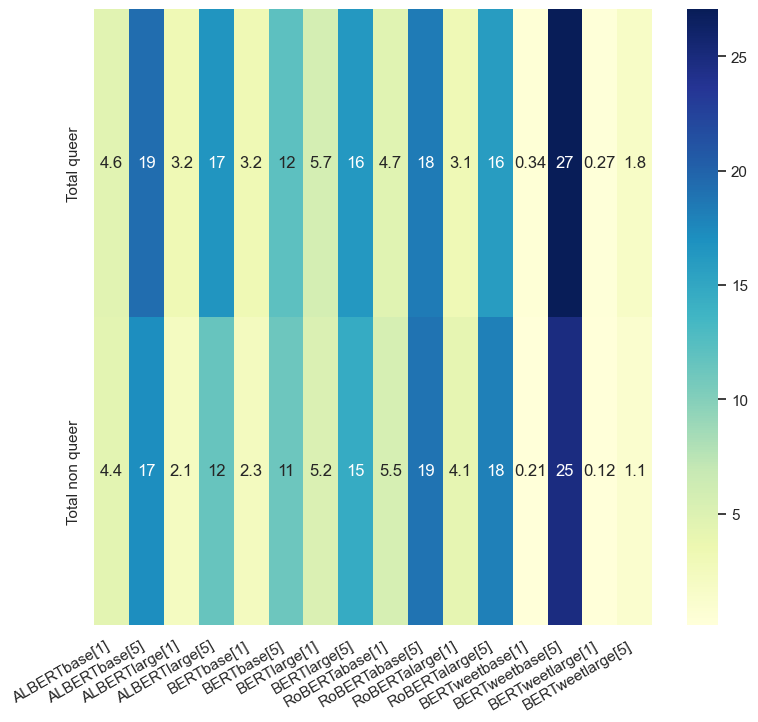

<Figure size 2000x1000 with 0 Axes>

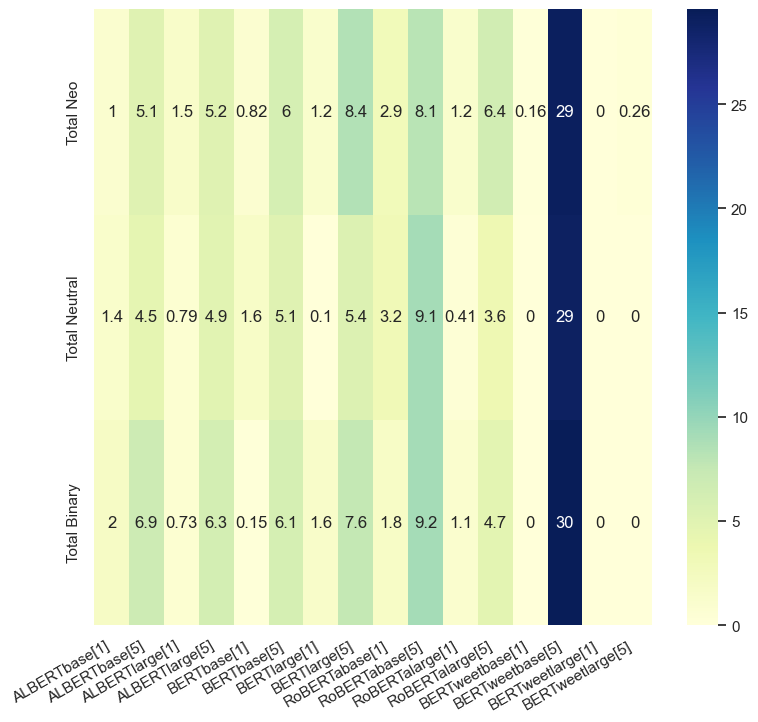

<Figure size 2000x1000 with 0 Axes>

In [51]:
def term_graph_score(final = False):
    # import file with data 
    data = pd.read_csv(RESULTS_PATH+'total_score_term.csv', sep=";", index_col=[0]) 
    data = (data[:6] if final == False else data[6:])
    # prints data that will be plotted 
    # columns shown here are selected by corr() since 
    # they are ideal for the plot 
    #print(data) 
    
    # plotting correlation heatmap 
    sb.set (rc = {'figure.figsize':(9, 8)})
    dataplot = sb.heatmap(data, cmap="YlGnBu", annot=True) 
    plt.xticks(rotation=30)
    plt.setp(dataplot.xaxis.get_majorticklabels(), ha='right')
    plt.figure(figsize=(20,10))
    # displaying heatmap 
    plt.show() 

def pronouns_graph_score(final = False):
    # import file with data 
    data = pd.read_csv(RESULTS_PATH+'total_score_pronouns.csv', sep=";", index_col=[0]) 
    data = (data[:9] if final == False else data[9:])
    # prints data that will be plotted 
    # columns shown here are selected by corr() since 
    # they are ideal for the plot 
    #print(data) 
    
    # plotting correlation heatmap 
    sb.set (rc = {'figure.figsize':(9, 8)})
    dataplot = sb.heatmap(data, cmap="YlGnBu", annot=True) 
    
    plt.xticks(rotation=30)
    plt.setp(dataplot.xaxis.get_majorticklabels(), ha='right')
    # displaying heatmap 
    plt.figure(figsize=(20,10))
    plt.show() 

term_graph_score(True)
pronouns_graph_score(True)